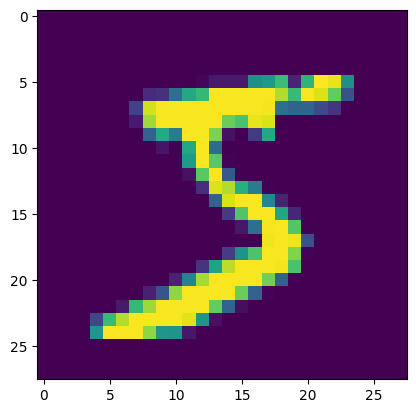

In [26]:
import torch
from torchvision import datasets, transforms
# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# 下载训练集
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
# 下载测试集
test_dataset = datasets.MNIST('data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

# show image
import matplotlib.pyplot as plt
import numpy

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(numpy.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow( next(iter(train_loader))[0][0] )

In [3]:
# uisng GPU


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [13]:
# show model size in each layer
model = Net()
model.to(device)
print(model)
for name, param in model.named_parameters():
    print(name, '\t', param.size())


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
conv1.weight 	 torch.Size([10, 1, 5, 5])
conv1.bias 	 torch.Size([10])
conv2.weight 	 torch.Size([20, 10, 5, 5])
conv2.bias 	 torch.Size([20])
fc1.weight 	 torch.Size([50, 320])
fc1.bias 	 torch.Size([50])
fc2.weight 	 torch.Size([10, 50])
fc2.bias 	 torch.Size([10])


In [20]:
#train
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = F.nll_loss(output, target.to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % 24 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

for epoch in range(1, 10):
    train(epoch)

C:\Users\Dandelion\AppData\Local\Temp\ipykernel_31408\3974891827.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323725
Train Epoch: 1 [1536/60000 (3%)]	Loss: 1.966425
Train Epoch: 1 [3072/60000 (5%)]	Loss: 1.114956
Train Epoch: 1 [4608/60000 (8%)]	Loss: 0.982850
Train Epoch: 1 [6144/60000 (10%)]	Loss: 0.654270
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.902084
Train Epoch: 1 [9216/60000 (15%)]	Loss: 0.684577
Train Epoch: 1 [10752/60000 (18%)]	Loss: 0.655656
Train Epoch: 1 [12288/60000 (20%)]	Loss: 0.793310
Train Epoch: 1 [13824/60000 (23%)]	Loss: 0.533346
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.713115
Train Epoch: 1 [16896/60000 (28%)]	Loss: 0.445419
Train Epoch: 1 [18432/60000 (31%)]	Loss: 0.662628
Train Epoch: 1 [19968/60000 (33%)]	Loss: 0.821292
Train Epoch: 1 [21504/60000 (36%)]	Loss: 0.348947
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.398657
Train Epoch: 1 [24576/60000 (41%)]	Loss: 0.573675
Train Epoch: 1 [26112/60000 (43%)]	Loss: 0.332475
Train Epoch: 1 [27648/60000 (46%)]	Loss: 0.337762
Train Epoch: 1 [29184/60000 (49%)]	Loss: 0.544432
Train Epoch: 1

In [ ]:
# test
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data.to(device))
        test_loss += F.nll_loss(output, target.to(device), size_average=False).item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.to(device).view_as(pred)).sum()

test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


C:\Users\Dandelion\AppData\Local\Temp\ipykernel_31408\3974891827.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.0442, Accuracy: 9860/10000 (99%)

